/usr/local/lib64/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


Error al generar la señal: float() argument must be a string or a number, not 'TensorVariable'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mass1, mass2]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.


         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mass1  27.591  12.995   6.068   47.704      0.292    0.214    1923.0   
mass2  27.291  13.024   5.005   46.799      0.304    0.215    1759.0   

       ess_tail  r_hat  
mass1    1336.0    1.0  
mass2    1196.0    1.0  


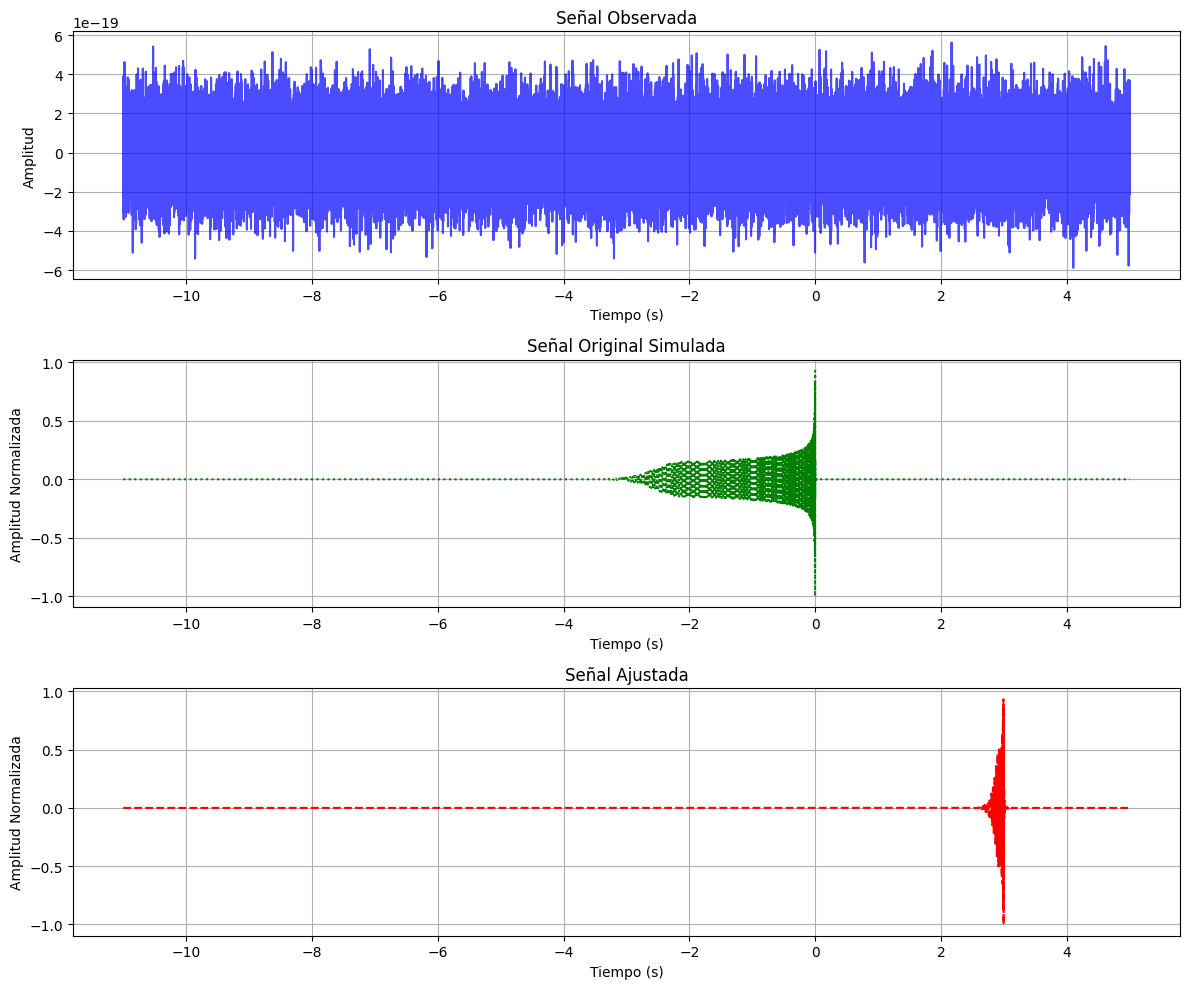

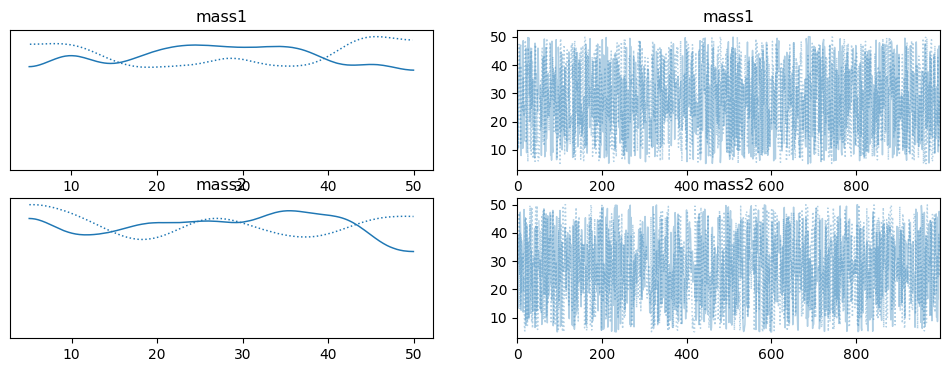

In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from pycbc.waveform import get_td_waveform

# Generar la onda gravitacional
hp_rom, hc_rom = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=6,
    mass2=6,
    delta_t=1.0 / 4096,
    f_lower=40
)

# Extraer tiempos de muestreo ANTES de convertir a numpy.ndarray
t = hp_rom.sample_times  # Esto accede a los tiempos de muestreo del objeto PyCBC.

# Convertir la señal a numpy.ndarray para su procesamiento
hp_rom = np.array(hp_rom)

# Generar ruido gaussiano
gaussian_noise = np.random.normal(size=t.shape[0])

# Escalar el ruido para igualar la amplitud máxima de la señal
max_value = np.max(np.abs(hp_rom))
scaled_noise = gaussian_noise * max_value

# Generar la señal observada
observed_signal = hp_rom + scaled_noise

# Generar una señal modelo
def generate_model_signal(mass1, mass2, approximant="SEOBNRv4_ROM"):
    hp, _ = get_td_waveform(
        approximant=approximant,
        mass1=mass1,
        mass2=mass2,
        delta_t=1.0 / 4096,
        f_lower=40.0
    )
    hp_np = np.array(hp)  # Convertimos a array de Numpy
    return hp_np / np.max(np.abs(hp_np))  # Normalizamos la señal

# Interpolación de señal
def interpolate_signal(signal, observed_times, model_times):
    return np.interp(observed_times, model_times, signal)

# Modelo probabilístico con PyMC
with pm.Model() as model:
    # Priors para las masas
    mass1 = pm.Uniform("mass1", lower=5, upper=50)
    mass2 = pm.Uniform("mass2", lower=5, upper=50)

    # Likelihood (Revisar bien-Preguntar)
    def likelihood_function(mass1, mass2):
        try:
            model_signal = generate_model_signal(mass1, mass2)
            model_times = np.linspace(0, len(model_signal) / 4096, len(model_signal))
            resampled_signal = interpolate_signal(model_signal, t, model_times)
            resampled_signal /= np.max(np.abs(resampled_signal))  # Normalización
            return resampled_signal
        except Exception as e:
            print(f"Error al generar la señal: {e}")
            return np.zeros_like(observed_signal)  # Retorna señal nula en caso de error

    # Generar señal modelo
    predicted_signal = likelihood_function(mass1, mass2)

    # Likelihood basada en la discrepancia entre señal observada y modelo
    likelihood = pm.Normal("likelihood", mu=predicted_signal, sigma=2, observed=observed_signal)

    # Iniciar el muestreo
    trace = pm.sample(1000, tune=500, chains=2)

# Resultados
print(pm.summary(trace))

# Valores medios de las masas ajustadas
mass1_mean = trace.posterior['mass1'].mean().values
mass2_mean = trace.posterior['mass2'].mean().values

# Señal ajustada usando los valores promedio de las masas
adjusted_signal = generate_model_signal(mass1_mean, mass2_mean)
adjusted_times = np.linspace(0, len(adjusted_signal) / 4096, len(adjusted_signal))
adjusted_signal_resampled = interpolate_signal(adjusted_signal, t, adjusted_times)
adjusted_signal_resampled /= np.max(np.abs(adjusted_signal_resampled))

# Graficar señales
plt.figure(figsize=(12, 10))

# Señal observada
plt.subplot(3, 1, 1)
plt.plot(t, observed_signal, label="Señal Observada (con Ruido)", color='blue', alpha=0.7)
plt.title("Señal Observada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()

# Señal original simulada
plt.subplot(3, 1, 2)
plt.plot(t, hp_rom / np.max(np.abs(hp_rom)), label="Señal Original (Simulada)", color='green', linestyle=':')
plt.title("Señal Original Simulada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

# Señal ajustada
plt.subplot(3, 1, 3)
plt.plot(t, adjusted_signal_resampled, label="Señal Ajustada", color='red', linestyle='--')
plt.title("Señal Ajustada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.grid()

plt.tight_layout()
# Graficar resultados con ArviZ
az.plot_trace(trace)
plt.show()